In [1]:
import boto3
import pandas as pd
from io import StringIO

s3 = boto3.client('s3')
BUCKET_NAME = 'sagemaker-crawling-s3-bucket'
DIR_NAME = 's&p/' #저장된 폴더명

#저장된 csv파일 모두 가져오기(1000개 이상의 객체 제한을 고려한 코드)
def list_all_objects(bucket_name, prefix=''):
    s3 = boto3.client('s3')
    objects = []
    continuation_token = None

    while True:
        if continuation_token:
            response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix, ContinuationToken=continuation_token)
        else:
            response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

        # 객체 추가
        objects.extend(response.get('Contents', []))

        # 다음 토큰 확인
        if response.get('NextContinuationToken'):
            continuation_token = response['NextContinuationToken']
        else:
            break

    return objects

all_objects = list_all_objects(BUCKET_NAME, prefix=DIR_NAME)
print(len(all_objects)) #전체 데이터 수

#.csv 파일을 읽어와서 데이터프레임으로 변환/ dfs 딕셔너리에 파일명 저장
dfs = {}
for obj in all_objects:
    file_key = obj['Key']
    if file_key.endswith('.csv'):
        file_content = s3.get_object(Bucket=BUCKET_NAME, Key=file_key)['Body'].read().decode('utf-8')
        df = pd.read_csv(StringIO(file_content))
        file_name = file_key.split('/')[-1].split('.')[0]
        dfs[file_name] = df

504


In [2]:
dfs

{'A':             Open        High         Low       Close    Volume  Dividends  \
 0      27.652461   30.387323   24.309857   26.740843  62546380        0.0   
 1      26.095116   26.133102   24.195910   24.537767  15234146        0.0   
 2      25.107524   26.740843   24.347840   26.740843   6577870        0.0   
 3      25.829221   26.512936   24.309855   24.309855   5975611        0.0   
 4      24.385825   25.487366   24.309856   24.955587   4843231        0.0   
 ...          ...         ...         ...         ...       ...        ...   
 6039  113.250000  114.500000  112.389999  113.980003   3050000        0.0   
 6040  121.459999  124.680000  121.230003  123.919998   6085800        0.0   
 6041  123.870003  125.400002  123.809998  123.989998   2630700        0.0   
 6042  123.919998  126.769997  123.480003  126.620003   1226700        0.0   
 6043  125.980003  126.680000  124.889999  125.010002   2255400        0.0   
 
       Stock Splits  
 0              0.0  
 1           

In [3]:
def hurst_exponent(time_series, max_lag):
    """
    Calculate the Hurst Exponent for a given time series.

    Parameters:
    - time_series: A pandas Series or similar array-like object representing a time series.
    - max_lag: The maximum lag (in terms of data points) to consider in the calculation.

    Returns:
    - H: The Hurst Exponent of the time series.
    """
    lags = range(2, max_lag)
    variances = [np.var(time_series.diff(lag)) for lag in lags]

    # Use log-log regression to estimate the Hurst Exponent
    log_vars = np.log(variances)
    log_lags = np.log(np.array(lags))
    poly = np.polyfit(log_lags, log_vars, 1)

    return poly[0] / 2

# Example usage:
# hurst_exponent(your_time_series)

In [6]:
len(dfs)

503

In [7]:
length = len(list(dfs.keys()))
length

503

In [8]:
import numpy as np

In [9]:
hurst_exponent_numpy = []

for i in range(length):
    h = dfs[list(dfs.keys())[i]]
    time_series = h['Close']
    
    try:
        max_lag = len(dfs[list(dfs.keys())[i]])*0.7 # 시간 구간을 정함. 여기서는 각 .csv 파일의 70%만 사용.
        max_lag = int(max_lag)
        hurst_exponent_result = hurst_exponent(time_series, max_lag)
        hurst_exponent_numpy.append([hurst_exponent_result,list(dfs.keys())[i]])
        print(hurst_exponent_result, list(dfs.keys())[i])
    except Exception as e:
        print(f"Error processing data for index {i}: {e}")

0.3897865509919131 A
0.1337343277796339 AAL
0.42759220148868543 AAPL
0.27640382876893266 ABBV
0.10698778934847256 ABNB
0.44057257669654093 ABT
0.36571534701659836 ACGL
0.42104020384231094 ACN
0.37641534046958286 ADBE
0.3996341532229932 ADI
0.31537648012665787 ADM
0.46056450850003405 ADP
0.36509009171640056 ADSK
0.42291748733440526 AEE
0.45684853707675493 AEP
0.1449013392601549 AES
0.37218462457297113 AFL
0.2421236790867289 AIG
0.3103962800225833 AIZ
0.4576720299362739 AJG
0.23139549206186097 AKAM
0.2870903154927621 ALB
0.2545144319276664 ALGN
0.2908544376049856 ALK
0.34483211569398614 ALL
0.14584609589297265 ALLE
0.31440125574897043 AMAT
0.08012174049175524 AMCR
0.2646444727626267 AMD
0.47621757967298955 AME
0.4351045216597013 AMGN
0.35385945546347414 AMP
0.4054622047025983 AMT
0.39114280448438876 AMZN
0.24618797353137922 ANET
0.3729636895284782 ANSS
0.47082432685495207 AON
0.42802479981857106 AOS
0.2201631482581794 APA
0.4426742878823366 APD
0.4789038648518457 APH
0.14079469913107653 

0.13932009859356753 NXPI
0.33961797684804196 O
0.440873941757329 ODFL
0.3411762270166417 OKE
0.27081262082997015 OMC
0.371101639317047 ON
0.31606852423947546 ORCL
0.47934362987107554 ORLY
0.1844442021093406 OTIS
0.15980666154025452 OXY
0.32069620642189106 PANW
0.2572872685012604 PARA
0.1766949226479641 PAYC
0.4079973678688319 PAYX
0.40714823497982816 PCAR
0.20706226501059913 PCG
0.17110928575631132 PEAK
0.4335142621864888 PEG
0.492375243032691 PEP
0.29119406420921856 PFE
0.23477315290853282 PFG
0.4616200046070774 PG
0.4656740123279423 PGR
0.4062444538284065 PH
0.23634001912230052 PHM
0.3654399754388573 PKG
0.35950517562946394 PLD
0.0756544398207075 PM
0.3363327729733832 PNC
0.3350156007866984 PNR
0.4447826301978984 PNW
0.35459617830863405 PODD
0.39320030528055727 POOL
0.39624587136096306 PPG
0.22196492994062786 PPL
0.13182288289763847 PRU
0.4379024901318694 PSA
0.13318243235414137 PSX
0.30945941269928934 PTC
0.3802004617471587 PWR
0.14790510978839738 PXD
0.3600509779585715 PYPL
0.23824

In [10]:
hurst_exponent_csv = []
for i in range(length):
    if (abs(hurst_exponent_numpy[i][0]) <= 0.2) | (abs(hurst_exponent_numpy[i][0]) >= 0.8):
        hurst_exponent_csv.append(list(dfs.keys())[i])
        print(list(dfs.keys())[i])

AAL
ABNB
AES
ALLE
AMCR
APTV
BAC
BEN
BG
BIIB
BK
BKR
BSX
BWA
C
CAH
CBOE
CE
CEG
CF
CFG
CHRW
CMA
COF
CSCO
CTRA
CTSH
DAL
DFS
DLR
DOW
DVA
DVN
EPAM
EQT
EXPE
F
FANG
FCX
FE
FFIV
FITB
FOX
FOXA
FTV
GE
GLW
GM
GS
HAL
HBAN
HES
HIG
HII
HLT
HPE
HST
INCY
INTC
INVH
IPG
IQV
IR
IVZ
JCI
JNPR
KEY
KIM
KMI
KMX
KVUE
L
LKQ
LVS
LW
LYB
MET
META
MGM
MHK
MOS
MRNA
MRO
MU
NEM
NRG
NTAP
NXPI
OTIS
OXY
PAYC
PEAK
PM
PRU
PSX
PXD
RCL
REG
RF
RL
SEDG
SEE
SLB
SPG
STT
SYF
TFC
TPR
TRGP
TXT
UAL
ULTA
VICI
VTR
WAB
WDC
WMB
WRK
WYNN
XRAY
XYL
ZBH
ZION


In [11]:
len(hurst_exponent_csv)

123

In [12]:
np.savetxt('hurst_exponent_500.txt',hurst_exponent_csv, fmt='%s')

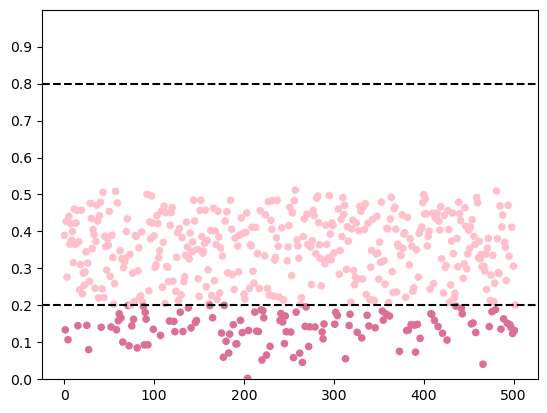

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# colors 설정
colors = ['PaleVioletRed' if abs(y[0]) <= 0.2 else 'Olive' if abs(y[0]) >= 0.8 else 'Pink' for y in hurst_exponent_numpy]

# 그래프 생성
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1, 0.1))
plt.scatter(range(len(hurst_exponent_numpy)), [y[0] for y in hurst_exponent_numpy], marker='o', s=20, color=colors)
plt.axhline(y=0.2, color='black', linestyle='--')
plt.axhline(y=0.8, color='black', linestyle='--')
plt.show()